In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [44]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import os
import ast
from adjustText import adjust_text

In [3]:
def load_result(file_path):
    with open(file_path, 'r') as f:
        # read last line and grab metrics info as a dict
        result = ast.literal_eval(f.readlines()[-1].split('[INFO] ')[1])

    return result
'''
    results_path: path to dir containing LAVIS output files
'''
def load_results(results_path):
    
    gather = []
    for file_name in os.listdir(results_path):
        file_path = os.path.join(results_path, file_name)
        result = load_result(file_path)
        result['file_name'] = file_name
        gather.append(result)
    
    df_results = pd.DataFrame(gather)
    
    weight_bits = df_results.file_name.str.extract(r'w(\d*)')
    df_results['weight_bits'] = [float(x) if x != '158' else 1.58 for x in weight_bits[0]]
    
    act_bits = df_results.file_name.str.extract(r'a(\d*)')
    df_results['activation_bits'] = [float(x) if x != '158' else 1.58 for x in act_bits[0]]

    return df_results

In [5]:
baseline_result = load_result(os.path.join('..', 'results', 'blip2_flickr', 'blip2_flickr_baseline.2714895'))
baseline_result['file_name'] = 'baseline'
baseline_result['weight_bits'] = 32.0
baseline_result['activation_bits'] = 32.0

baseline_result = pd.DataFrame([baseline_result])
baseline_result

,txt_r1,txt_r5,txt_r10,txt_r_mean,img_r1,img_r5,img_r10,img_r_mean,r_mean,agg_metrics,file_name,weight_bits,activation_bits
0,97.6,100.0,100.0,99.2,89.74,98.18,98.94,95.62,97.41,99.2,baseline,32.0,32.0


## Uniform Quantization

+ https://pocketflow.github.io/uq_learner/#algorithm

In [6]:
results_path = os.path.join('..', 'results', 'blip2_flickr', 'uniform_quant', 'vision_attention_head')
results_path

'../results/blip2_flickr/uniform_quant/vision_attention_head'

In [7]:
df_results = load_results(results_path)

df_results = pd.concat([baseline_result, df_results], axis = 0)
df_results

,txt_r1,txt_r5,txt_r10,txt_r_mean,img_r1,img_r5,img_r10,img_r_mean,r_mean,agg_metrics,file_name,weight_bits,activation_bits
0,97.6,100.0,100.0,99.200000,89.74,98.18,98.94,95.620000,97.410000,99.200000,baseline,32.00,32.0
0,52.7,70.2,76.1,66.333333,47.20,67.50,74.72,63.140000,64.736667,66.333333,vit_w4_a32,4.00,32.0
1,54.2,71.5,78.2,67.966667,49.04,69.46,76.70,65.066667,66.516667,67.966667,vit_w6_a32,6.00,32.0
2,18.0,30.4,37.8,28.733333,19.14,34.06,41.46,31.553333,30.143333,28.733333,vit_w2_a32,2.00,32.0
3,58.0,76.6,83.0,72.533333,56.70,76.12,81.72,71.513333,72.023333,72.533333,vit_w158_a32,1.58,32.0
4,55.2,72.2,78.1,68.500000,49.52,70.14,77.38,65.680000,67.090000,68.500000,vit_w8_a32,8.00,32.0


In [45]:
def plot(df, x, y, title = ''):
    
    sns.set_theme()
    ax = sns.lineplot(data= df,
                      x = x,
                      y = y,
                      marker = 'o')

    texts = []
    
    # label points on the plot
    for x_val, y_val in zip(df[x], df[y]):
        texts.append(plt.text(x = x_val, 
                              y = y_val, 
                              s = f'{y_val:.2f}', 
                              color = 'blue'))

    
    x_ticks = np.append(ax.get_xticks(), df[x])

    # Set xtick locations to the values of the array `x_ticks`
    ax.set_xticks(x_ticks)
    ax.invert_xaxis()
    
    adjust_text(texts, only_move={'points':'y', 'texts':'y'}, arrowprops=dict(arrowstyle="->", color='r', lw=0.5))
    
    plt.title(title)
    plt.ylabel(y)

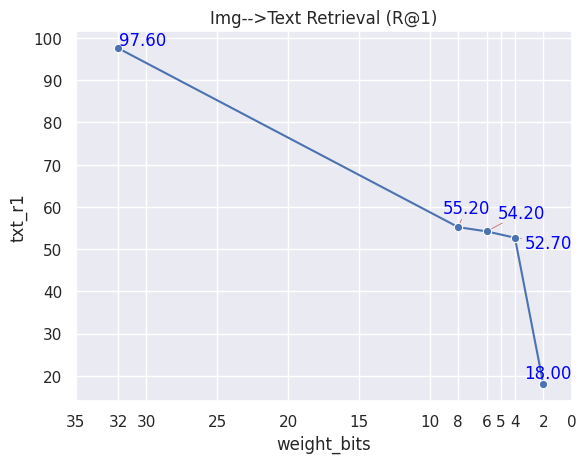

In [49]:
plot(df_results[df_results.weight_bits >= 2.0], 
     x = 'weight_bits', 
     y = 'txt_r1',
     title = 'Img-->Text Retrieval (R@1)')

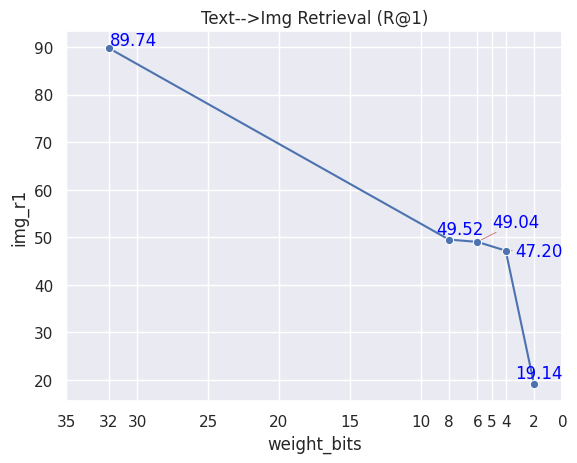

In [50]:
plot(df_results[df_results.weight_bits >= 2.0], 
     x = 'weight_bits', 
     y = 'img_r1',
     title = 'Text-->Img Retrieval (R@1)')